<a href="https://colab.research.google.com/github/SachinPrasanth777/PyTorch/blob/main/FashionMNISTValidationDropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
import torch.nn.functional as F

In [9]:
from torchvision import datasets,transforms
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
trainset = datasets.FashionMNIST('~/.pytorch/MNIST_data/',download=True,train=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True)
testset = datasets.FashionMNIST('~/.pytorch/MNIST_data/',download=True,train=False,transform=transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=64,shuffle=True)

In [10]:
print(len(trainset))
print(len(testset))

60000
10000


In [11]:
image,label = next(iter(trainloader))
print(image.shape)
print(label.shape)
uniques = trainset.targets
print(len(uniques.unique()))

torch.Size([64, 1, 28, 28])
torch.Size([64])
10


In [12]:
class_names = trainset.classes
print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [38]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784,256)
    self.fc2 = nn.Linear(256,128)
    self.fc3 = nn.Linear(128,64)
    self.fc4 = nn.Linear(64,10)
    self.dropout = nn.Dropout(p=0.2)
  def forward(self,x):
    x = x.view(x.shape[0],-1)
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.dropout(F.relu(self.fc3(x)))
    x = F.log_softmax(self.fc4(x),dim=1)
    return x

In [39]:
model = Classifier()
model

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [40]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.003)

In [41]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:

        optimizer.zero_grad()

        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    else:
        test_loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        model.train()

        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.611..  Test Loss: 0.520..  Test Accuracy: 0.805
Epoch: 2/30..  Training Loss: 0.484..  Test Loss: 0.473..  Test Accuracy: 0.838
Epoch: 3/30..  Training Loss: 0.462..  Test Loss: 0.420..  Test Accuracy: 0.848
Epoch: 4/30..  Training Loss: 0.432..  Test Loss: 0.420..  Test Accuracy: 0.853
Epoch: 5/30..  Training Loss: 0.428..  Test Loss: 0.395..  Test Accuracy: 0.860
Epoch: 6/30..  Training Loss: 0.411..  Test Loss: 0.396..  Test Accuracy: 0.859
Epoch: 7/30..  Training Loss: 0.404..  Test Loss: 0.415..  Test Accuracy: 0.854
Epoch: 8/30..  Training Loss: 0.400..  Test Loss: 0.398..  Test Accuracy: 0.857
Epoch: 9/30..  Training Loss: 0.393..  Test Loss: 0.401..  Test Accuracy: 0.858
Epoch: 10/30..  Training Loss: 0.387..  Test Loss: 0.425..  Test Accuracy: 0.858
Epoch: 11/30..  Training Loss: 0.384..  Test Loss: 0.399..  Test Accuracy: 0.864
Epoch: 12/30..  Training Loss: 0.384..  Test Loss: 0.384..  Test Accuracy: 0.869
Epoch: 13/30..  Training Loss: 0.380.

In [42]:
def view_classify(img, ps, version="MNIST"):
    '''
    Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='Greys_r')
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))

    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

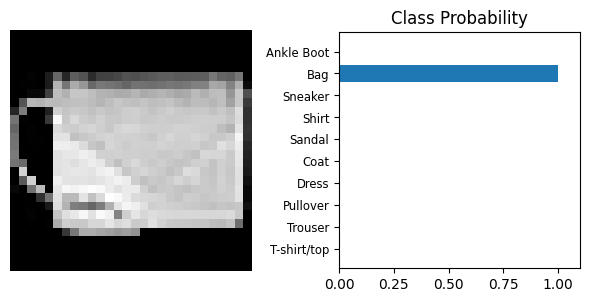

In [43]:
img = images[1].view(1, 784)
with torch.no_grad():
  log_ps = model(img)
ps = torch.exp(log_ps)
view_classify(img.view(1, 28, 28), ps, version='Fashion')

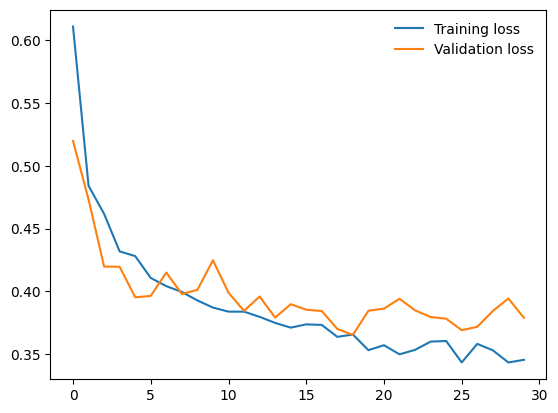

In [44]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)